In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
import matplotlib.pyplot as plt

In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore

def train_model(landmarks_file, model_output_path, encoder_output_path):
    """
    Train a model using the stored landmarks with absolute paths.
    """
    # Ensure the paths are absolute
    landmarks_file = os.path.abspath(landmarks_file)
    model_output_path = os.path.abspath(model_output_path)
    encoder_output_path = os.path.abspath(encoder_output_path)
    
    # Load landmarks data
    with open(landmarks_file, 'r') as f:
        landmarks_data = json.load(f)
    
    # Prepare data for training
    X = []  # Landmark coordinates
    y = []  # Class labels
    
    for image_path, data in landmarks_data.items():
        # Flatten landmarks array (21 landmarks × 3 coordinates = 63 features)
        landmarks_flat = np.array(data['landmarks']).flatten()
        X.append(landmarks_flat)
        y.append(data['class'])
    
    X = np.array(X)
    y = np.array(y)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    
    # Create model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(63,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()
    
    # Save model and label encoder
    model.save(model_output_path)
    np.save(encoder_output_path, label_encoder.classes_)
    print(f"Model saved to {model_output_path}")
    print(f"Label encoder saved to {encoder_output_path}")


C:\Users\Kartavya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2825 - loss: 2.0486 - val_accuracy: 0.8579 - val_loss: 0.9956
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6831 - loss: 1.0032 - val_accuracy: 0.9561 - val_loss: 0.3416
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8641 - loss: 0.5179 - val_accuracy: 0.9819 - val_loss: 0.1716
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9279 - loss: 0.3005 - val_accuracy: 0.9897 - val_loss: 0.0794
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9647 - loss: 0.1717 - val_accuracy: 0.9819 - val_loss: 0.0509
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9545 - loss: 0.1600 - val_accuracy: 0.9871 - val_loss: 0.0407
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9791 - loss: 0.0990 - val_accuracy: 0.9948 - val_loss: 0.0326
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9833 - loss: 0.0877 - val_accuracy: 0.9948 - val_loss

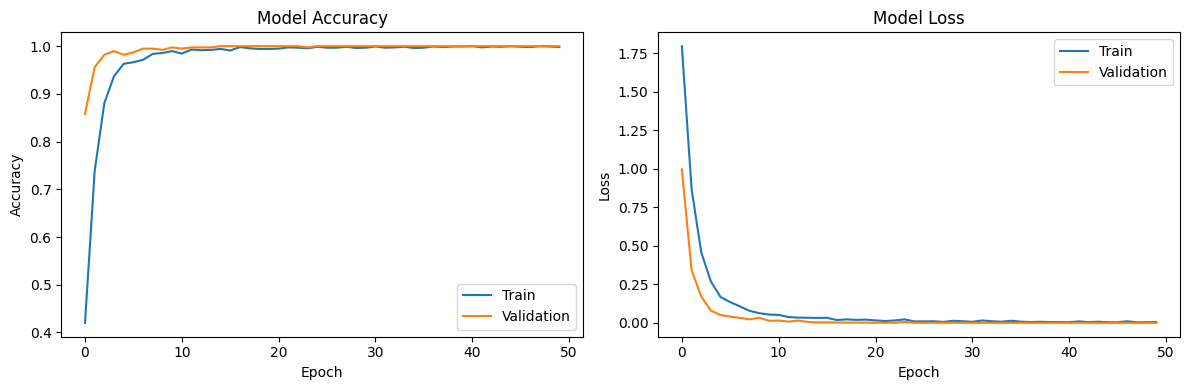

Model saved to C:\Users\Kartavya\.vscode\.vscode\Hand-Recognition\gesture_model.h5
Label encoder saved to C:\Users\Kartavya\.vscode\.vscode\Hand-Recognition\label_encoder.npy


In [10]:
# Usage
landmarks_file = r"C:\Users\Kartavya\.vscode\.vscode\Hand-Recognition\landmarks.json"
model_output_path = r"C:\Users\Kartavya\.vscode\.vscode\Hand-Recognition\gesture_model.h5"
encoder_output_path = r"C:\Users\Kartavya\.vscode\.vscode\Hand-Recognition\label_encoder.npy"

train_model(landmarks_file, model_output_path, encoder_output_path)

In [15]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import os

# Load the trained model
model = tf.keras.models.load_model(model_output_path)

# Gesture classes inferred from directory names
gesture_classes = [
    'closed_fist','middle-up','open_palm','point_down','point_left','point_right','point_up','point_down','yaw_left','yaw_right','yo'
]

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Function to normalize landmarks
def normalize_landmarks(landmarks):
    points = np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark])
    wrist = points[0]
    middle_mcp = points[9]
    points_normalized = points - wrist
    scale_factor = np.linalg.norm(points_normalized[9])
    if scale_factor != 0:
        points_normalized = points_normalized / scale_factor
    return points_normalized.flatten()

# Real-time gesture detection
def real_time_detection():
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5
    ) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]

                # Get bounding box coordinates
                h, w, _ = frame.shape
                x_min = min([lm.x for lm in hand_landmarks.landmark]) * w
                y_min = min([lm.y for lm in hand_landmarks.landmark]) * h
                x_max = max([lm.x for lm in hand_landmarks.landmark]) * w
                y_max = max([lm.y for lm in hand_landmarks.landmark]) * h

                # Normalize landmarks
                normalized_landmarks = normalize_landmarks(hand_landmarks)

                # Predict gesture
                prediction = model.predict(normalized_landmarks.reshape(1, -1), verbose=0)
                predicted_class_index = np.argmax(prediction)
                predicted_class = gesture_classes[predicted_class_index]
                confidence = np.max(prediction)

                # Draw landmarks on the frame
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                    mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )

                # Draw bounding box
                cv2.rectangle(
                    frame,
                    (int(x_min), int(y_min)),
                    (int(x_max), int(y_max)),
                    (0, 255, 255),
                    2
                )

                # Display prediction and confidence if above threshold
                if confidence > 0.8:
                    cv2.putText(
                        frame,
                        f"{predicted_class}",
                        (int(x_min), int(y_min) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 0, 0),
                        2
                    )
                else:
                    cv2.putText(
                        frame,
                        "No gesture",
                        (int(x_min), int(y_min) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 0, 255),
                        2
                    )
            else:
                cv2.putText(
                    frame,
                    "No gesture detected",
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2
                )

            # Show the frame
            cv2.imshow("Hand Gesture Recognition", frame)

            # Break loop on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

# Run real-time detection
real_time_detection()